In [1]:
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import random, numpy as np, os
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.run_functions_eagerly(True)
def config_gpu(mp=False):
    print('Eager Model : ', tf.executing_eagerly())
    print('TensorFlow Cuda Built Test : ', tf.test.is_built_with_cuda)
    print('TensorFlow GPU Detected : ', tf.test.gpu_device_name())
    print('TensorFlow System Cuda Version : ', tf.sysconfig.get_build_info()["cuda_version"])
    print('TensorFlow System CudNN Version : ', tf.sysconfig.get_build_info()["cudnn_version"] )

    AUTO = tf.data.AUTOTUNE
    GPUS = tf.config.list_physical_devices('GPU')
    if GPUS:
        try:
            for GPU in GPUS:
                tf.config.experimental.set_memory_growth(GPU, True)
                logical_gpus = tf.config.list_logical_devices('GPU')
                print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
        except RuntimeError as  RE:
            print(RE)
    if mp:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print('Mixed precision enabled')
        
#tf.keras.utils.set_random_seed(100)
config_gpu(mp=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Eager Model :  True
TensorFlow Cuda Built Test :  <function is_built_with_cuda at 0x7bc6a8ff9b40>
TensorFlow GPU Detected :  /device:GPU:0
TensorFlow System Cuda Version :  11.8
TensorFlow System CudNN Version :  8
1 Physical GPUs, 1 Logical GPUs


# <a id='intro'>Plan</a>
#### [Wavelet with residual block](#the_destination)
#### [Efficient-net](#Efficient_net)
#### [Ensemblelearning](#Ensemble_learning)
#### [Metrics with Graph](#graph)
#### [Grad-CAM](#Gradcam)
#### [Result Metrics](#metrics)

# <a id=''>TF Dataset and Preprocess</a>

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from keras.layers import Lambda
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile

In [3]:
import os, cv2
import random, math
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import tensorflow, keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

In [4]:
metadata_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
train_path = r'/kaggle/input/basedir/base_dir/train_dir/'
test_path = '/kaggle/input/basedir/base_dir/val_dir/'
batch_size = 16

train_batch_size = 4
val_batch_size = 4
image_size = 224

In [6]:
def custom_augmentation(np_tensor):

  def random_contrast(np_tensor):
    return np.array(tf.image.random_contrast(np_tensor, 0.5, 2))

  def random_saturation(np_tensor):
    return np.array(tf.image.random_saturation(np_tensor, 0.2, 3))

  def random_crop(np_tensor):
    #cropped height between 70% to 130% of an original height
    new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
    #cropped width between 70% to 130% of an original width
    new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
    # resize to new height and width
    cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
    return np.array(tf.image.resize(cropped, np_tensor.shape[:2]))

  def gaussian_noise(np_tensor):
    mean = 0
    # variance: randomly between 1 to 25
    var = np.random.randint(1, 26)
    # sigma is square root of the variance value
    noise = np.random.normal(mean,var**0.5,np_tensor.shape)
    return np.clip(np_tensor + noise, 0, 255).astype('int')

  def cutout(np_tensor):
    cutout_height = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[0])
    cutout_width = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[1])
    cutout_height_point = np.random.randint(np_tensor.shape[0]-cutout_height)
    cutout_width_point = np.random.randint(np_tensor.shape[1]-cutout_width)
    np_tensor[cutout_height_point:cutout_height_point+cutout_height, cutout_width_point:cutout_width_point+cutout_width, :] = 127
    return np_tensor

  if (np.random.uniform() < 0.1):
    np_tensor = random_contrast(np_tensor)
  if (np.random.uniform() < 0.1):
    np_tensor = random_saturation(np_tensor)
  if (np.random.uniform() < 0.2):
    np_tensor = random_crop(np_tensor)
  if (np.random.uniform() < 0.2):
    np_tensor = gaussian_noise(np_tensor)
  if (np.random.uniform() < 0.3):
    np_tensor = cutout(np_tensor)
  return np.array(np_tensor)

In [7]:

datagen = ImageDataGenerator(#preprocessing_function=custom_augmentation,
                            rescale=1./255,
                             preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                            horizontal_flip = True,
                            vertical_flip=True
)
datagen1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                             rescale=1./255,)
                             #horizontal_flip = True,
                             #vertical_flip=True,)


train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size,)
                                           #subset='training')

valid_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,)

test_batches = datagen1.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=32,
                                            shuffle=False,)
                                          #subset='validation')

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


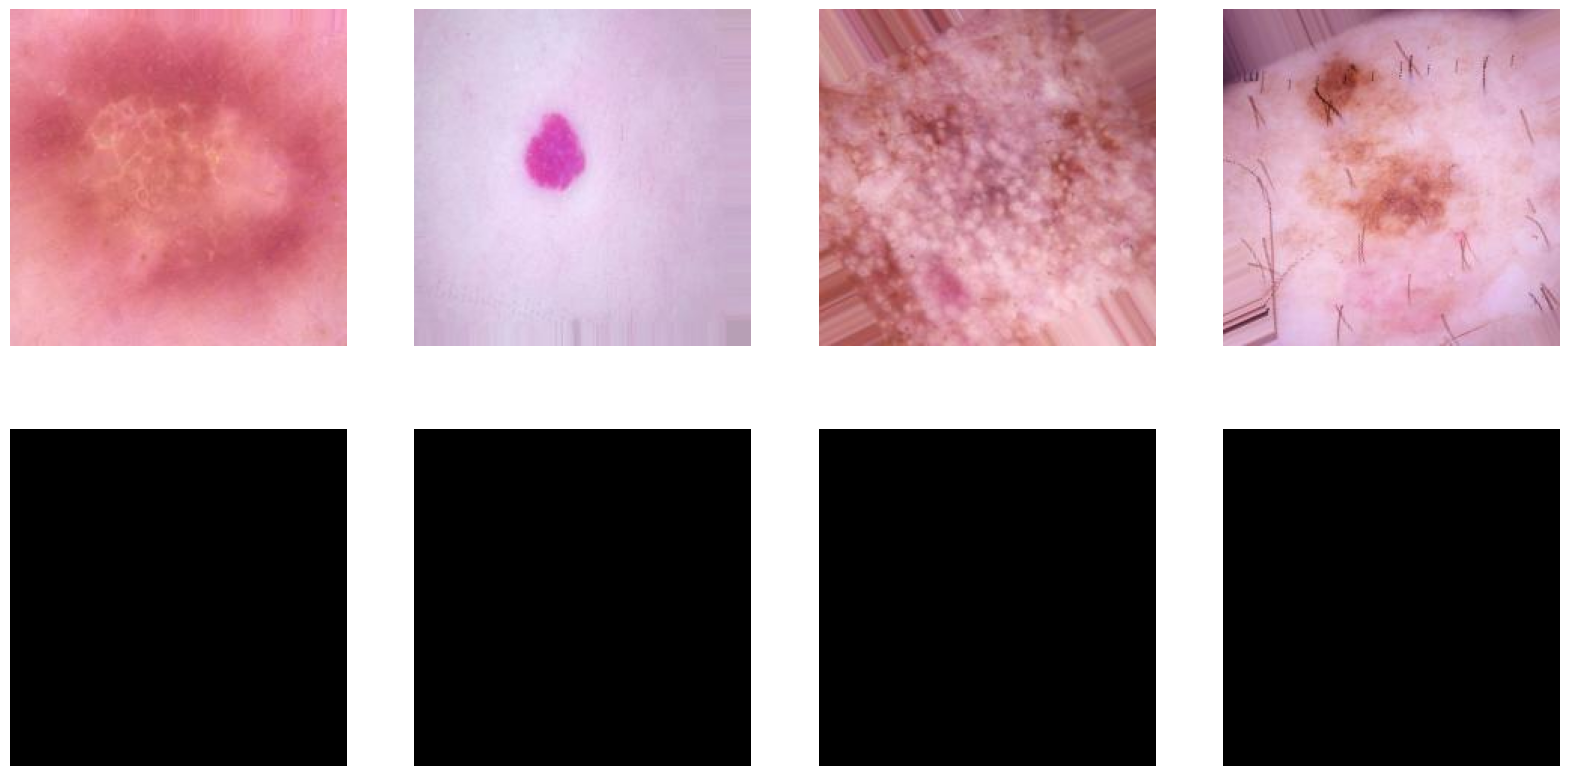

In [8]:
#densneet
%matplotlib inline
image, label = next(train_batches)
plt.figure(figsize=(20,10))
inline = 4
for i in range(inline):
    #print(image.size())
    plt.subplot(2, inline, i%inline +1)
    plt.axis('off')
    plt.imshow(image[i])
    #plt.title(f'Label: {label}')
    plt.subplot(2, inline, i%inline +5)
    plt.axis('off')
    plt.imshow(image[i].astype(np.uint8))

# Configuration

In [9]:
# Setting TPU as main device for training, if you get warnings while working with tpu's ignore them.

DEVICE = 'TPU'
if DEVICE == 'TPU':
    print('connecting to TPU...')
    try:        
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None

    if tpu:
        try:
            print('Initializing  TPU...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print('TPU initialized')
        except _:
            print('Failed to initialize TPU!')
    else:
        DEVICE = 'GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    print('Num GPUs Available: ',
          len(tf.config.experimental.list_physical_devices('GPU')))

print('REPLICAS: ', strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS:  1


In [10]:
cfg = dict(
           batch_size=4,
           img_size=384,
    
           lr_start=0.000005,
           lr_max=0.0000125,
           lr_min=0.000001,
           lr_rampup=5,
           lr_sustain=0,
           lr_decay=0.8,
           epochs=12,
    
           transform_prob=1.0,
           rot=180.0,
           shr=2.0,
           hzoom=8.0,
           wzoom=8.0,
           hshift=8.0,
           wshift=8.0,
    
           optimizer='sgd',
           label_smooth_fac=0.05,
           tta_steps=20
            
        )

# <a id='the_destination'>Wavelet with residual block</a>
#### [Return Contents](#intro)

In [11]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [12]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2,decom_level_3,decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [13]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Fonction pour créer un bloc résiduel
def residual_block(x, filters, strides=(1, 1)):
    # Couches de convolution du bloc résiduel
    shortcut = x
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    # Connexion résiduelle
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])
        
def cbam_block(input_tensor, ratio=8):
    # Channel Attention
    channels = input_tensor.shape[-1]
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    shared_fc = Dense(channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(avg_pool)
    ca_weights = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(shared_fc)
    ca_output = multiply([input_tensor, ca_weights])

    # Spatial Attention
    max_pool = Reshape((1, 1, channels))(GlobalMaxPooling2D()(ca_output))
    spatial_weights = Conv2D(1, (7, 7), activation='sigmoid', padding='same', kernel_initializer='he_normal', use_bias=False)(max_pool)
    spatial_output = multiply([ca_output, spatial_weights])

    return spatial_output


def get_wavelet_cnn_model():
    input_shape = 224, 224, 3

    input_ = Input(input_shape, name='the_input')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    # Adjust the number of channels in wavelet decomposition output
    input_l1 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l1')(input_l1)
    input_l2 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l2')(input_l2)
    input_l3 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l3')(input_l3)
    input_l4 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l4')(input_l4)

    # Architecture ResNet avec les blocs résiduels et les blocs de transformation en ondelettes

    x = input_
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Niveau 1
    x = input_l1
    relu_a = residual_block(x, filters=64, strides=(2, 2))
    relu_a = cbam_block(relu_a)

    # Niveau 2
    x = input_l2
    for _ in range(2):
        relu_1_2 = residual_block(x, filters=64)
    relu_1_2 = cbam_block(relu_1_2)

    print("conc")
    concate_level_2 = concatenate([relu_1_2, relu_a])
    relu_2_2 = residual_block(concate_level_2, filters=128, strides=(2, 2))
    print(relu_2_2)

    x = input_l3
    relu_b_2 = residual_block(x, filters=64)
    for _ in range(2):
        relu_b_2 = residual_block(relu_b_2, filters=128)
    relu_b_2 = cbam_block(relu_b_2)

    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    print("conc")
    print(concate_level_3)
    relu_3_2 = residual_block(concate_level_3, filters=256, strides=(2, 2))

    # Niveau 3
    x = input_l4
    relu_c_3 = residual_block(x, filters=64)
    for _ in range(2):
        relu_c_3 = residual_block(relu_c_3, filters=256)
    relu_c_3 = cbam_block(relu_c_3)
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    print("conc")
    print(concate_level_4)
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1)

    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(7, activation='softmax', name='fc_7')(drop_6)

    model = Model(inputs=input_, outputs=output)

    return model

In [14]:
#wavelet model
wavelet = get_wavelet_cnn_model()

conc
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 128), dtype=tf.float32, name=None), name='activation_8/Relu:0', description="created by layer 'activation_8'")
conc
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 256), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
conc
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


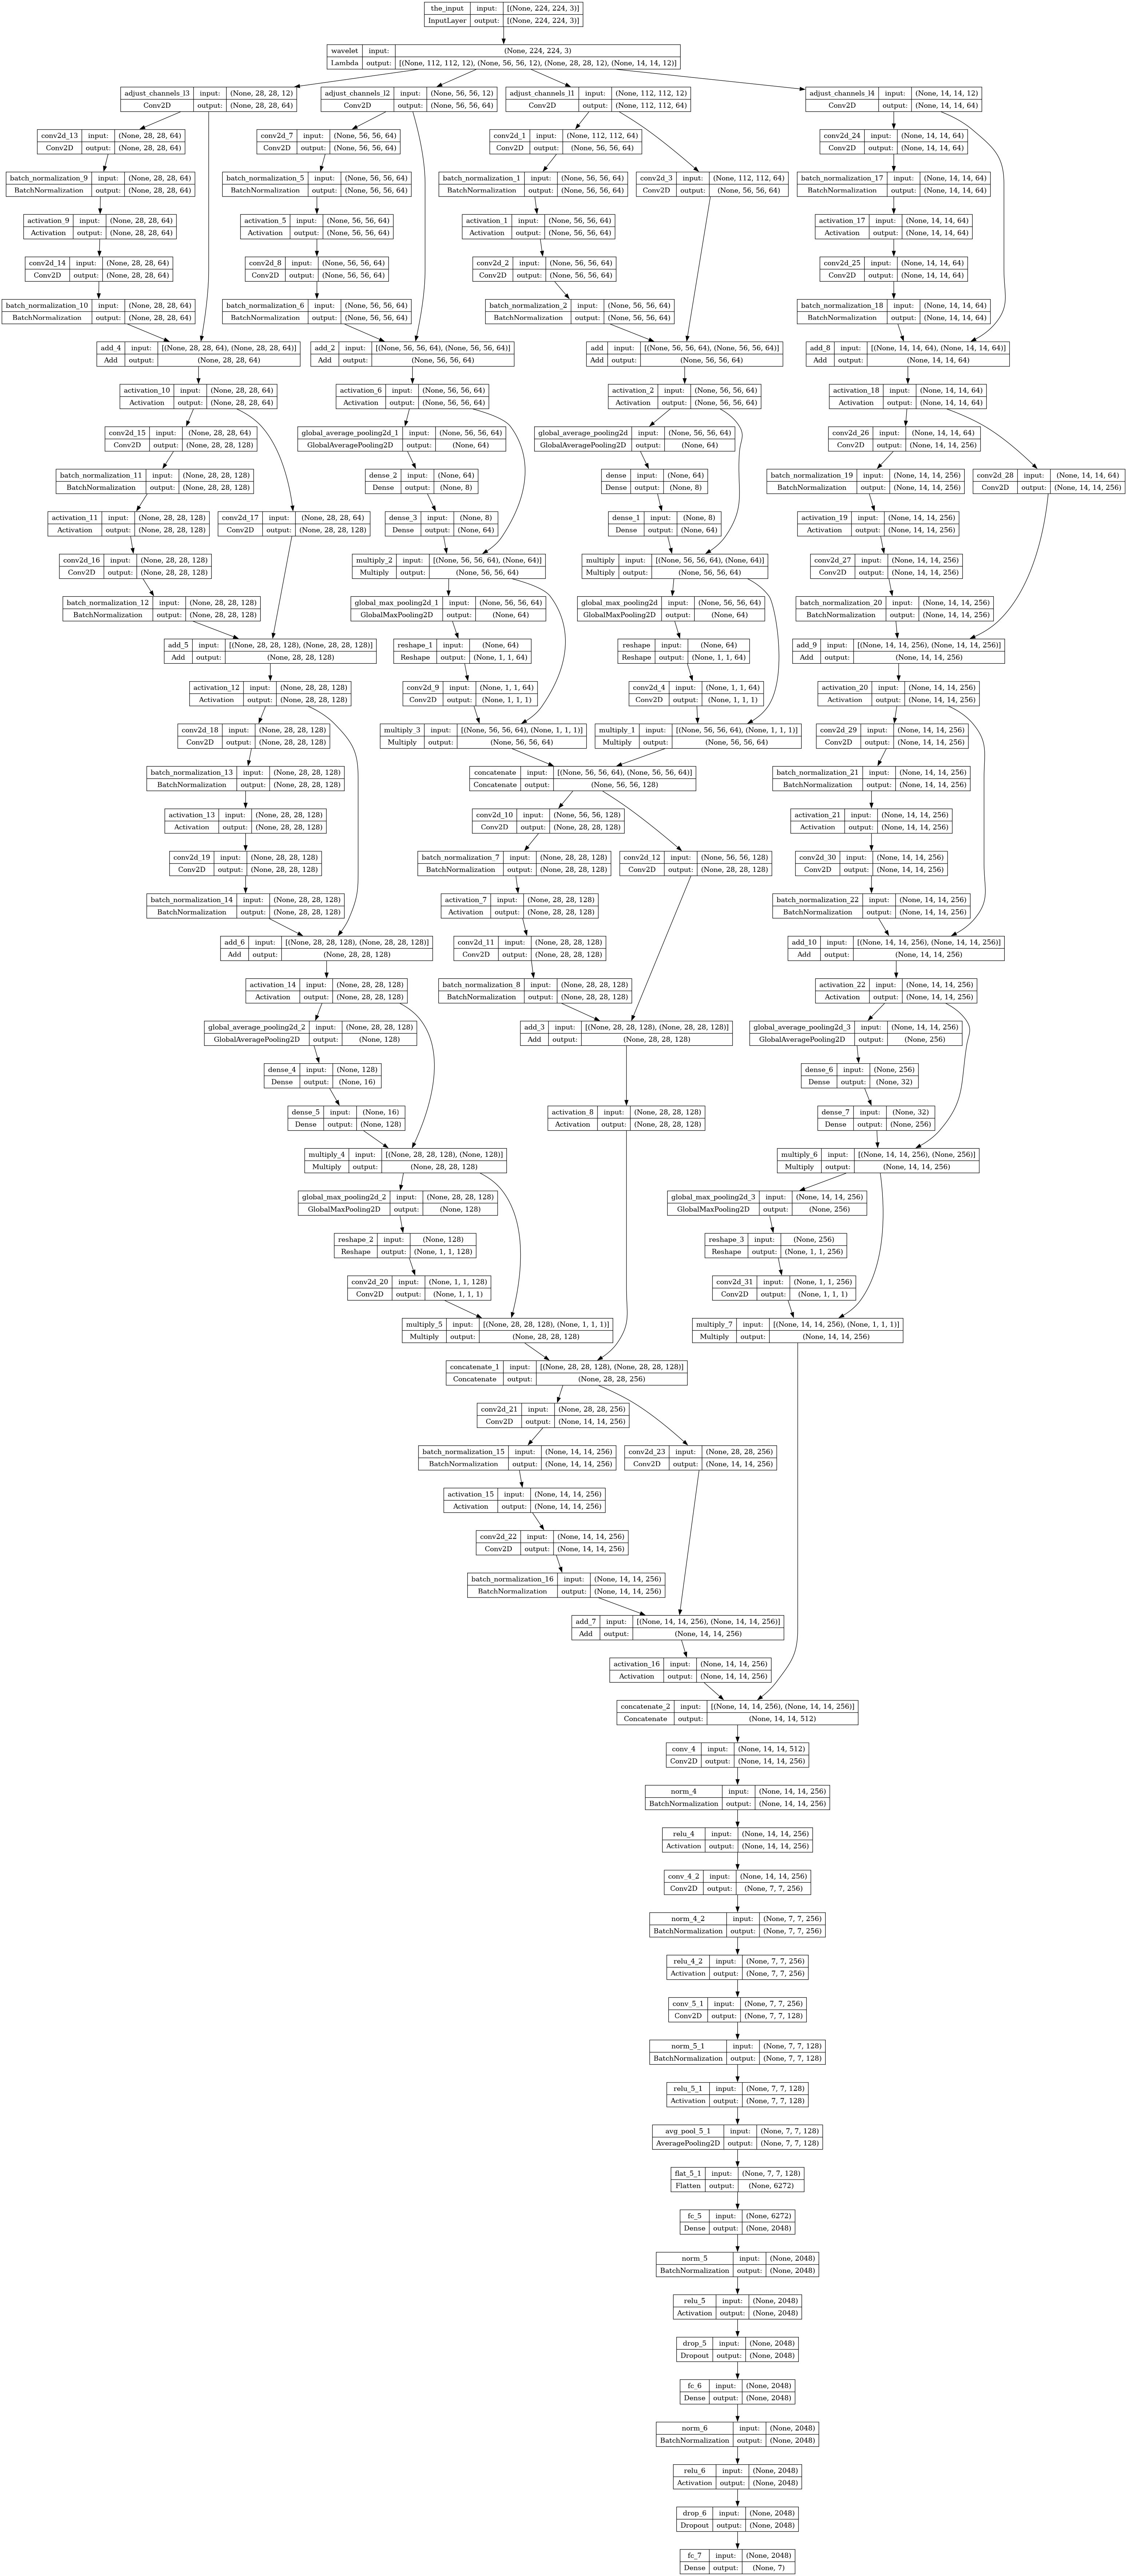

In [15]:
import tensorflow as tf 
display(tf.keras.utils.plot_model(wavelet, 
                                  show_shapes=True, 
                                  show_layer_names=True,
                                  expand_nested=True))

In [16]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

# Multi-Atrous Branch
class MultiAtrous(keras.Model):
    def __init__(self, 
                 dilation_rates=[6, 12, 18], 
                 upsampling=1, 
                 kernel_size=3, 
                 padding="same",  **kwargs):
        super(MultiAtrous, self).__init__(name='MultiAtrous', **kwargs)
        self.dilation_rates = dilation_rates
        self.kernel_size = kernel_size 
        self.upsampling = upsampling
        self.padding = padding
      
        # Dilated Convolutions                     
        self.dilated_convs = [
                              layers.Conv2D(
                                  filters       = int(1024 / 4), 
                                  kernel_size   = self.kernel_size,  
                                  padding       = self.padding, 
                                  dilation_rate = rate
                                ) for rate in self.dilation_rates
                             ]
        
        # Global Average Pooling Branch 
        self.gap_branch = keras.Sequential(
            [
                layers.GlobalAveragePooling2D(keepdims=True),
                layers.Conv2D(int(1024 / 2), kernel_size=1),
                layers.Activation('relu'),
                layers.UpSampling2D(size=self.upsampling, interpolation="bilinear")
            ] , name='gap_branch'
        )
        
    def call(self, inputs, training=None, **kwargs):
        local_feature = []
        for dilated_conv in self.dilated_convs:
            x = dilated_conv(inputs) 
            x = self.gap_branch(x)
            local_feature.append(x)
        return tf.concat(local_feature, axis=-1)

    def get_config(self):
        config = {
            'dilation_rates': self.dilation_rates,
            'kernel_size'   : self.kernel_size,
            'padding'       : self.padding,
            'upsampling'    : self.upsampling
        }
        base_config = super(MultiAtrous, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-6, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon   = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(name="norms", 
                                 shape=(input_shape[-1],),
                                 initializer=keras.initializers.constant(self.init_norm),
                                 trainable=True)
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))
        x = tf.pow(x, self.p)
        x = tf.reduce_mean(x, axis=[1,2], keepdims=False) 
        x = tf.pow(x, (1.0 / self.p))
        if self.normalize:
            x = tf.nn.l2_normalize(x, 1)
        return x

    def get_config(self):
        config = {
            'init_norm' : self.init_norm,
            'normalize' : self.normalize,
            'epsilon'   : self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [18]:
class SkinNet(keras.Model):
    def __init__(self, backbone=None, num_classes=1, activation=None, **kwargs):
        super(SkinNet, self).__init__(name='SkinNet', **kwargs)
        # Number of classes 
        self.num_classes = num_classes
        self.activation  = activation
        
        # Base blcoks 
        self.base = backbone
        self.base_input_shape  = self.base.input_shape[0][1]

        self.glob_branch_pool = keras.Sequential(
            [
                GeneralizedMeanPooling2D(),
                layers.Dense(1024, activation=None)
            ], 
            name='GlobalBranchPooling'
        )
        
        # Head block
        self.classifier = keras.Sequential(
            [
                #layers.GlobalAveragePooling2D(name='HeadGAP'),
                layers.Dense(self.num_classes, activation = self.activation)
            ], 
            name='Classifiers'
        )
       
    # forwarding the computation 
    def call(self, inputs, training=None, **kwargs):
        # Get tensor from target layers 
        to_global= self.base(inputs)

        # Pass the received tensor to Top building blocks 
        global_feat    = self.glob_branch_pool(to_global)
        return self.classifier(global_feat)
    """
    def train_step(self, data):
        return train_step_sam(self, data, rho=0.05)
    """

    def build_graph(self):
        x = keras.Input(shape=(self.base_input_shape, self.base_input_shape, 3))
        return keras.Model(inputs=[x], outputs=self.call(x))

In [19]:
from tensorflow.keras import applications, layers, Model, Input

for l in wavelet.layers:
    print(l.name, l.output_shape)  

the_input [(None, 224, 224, 3)]
wavelet [(None, 112, 112, 12), (None, 56, 56, 12), (None, 28, 28, 12), (None, 14, 14, 12)]
adjust_channels_l3 (None, 28, 28, 64)
conv2d_13 (None, 28, 28, 64)
batch_normalization_9 (None, 28, 28, 64)
activation_9 (None, 28, 28, 64)
conv2d_14 (None, 28, 28, 64)
batch_normalization_10 (None, 28, 28, 64)
adjust_channels_l2 (None, 56, 56, 64)
adjust_channels_l1 (None, 112, 112, 64)
add_4 (None, 28, 28, 64)
conv2d_7 (None, 56, 56, 64)
conv2d_1 (None, 56, 56, 64)
activation_10 (None, 28, 28, 64)
batch_normalization_5 (None, 56, 56, 64)
batch_normalization_1 (None, 56, 56, 64)
conv2d_15 (None, 28, 28, 128)
adjust_channels_l4 (None, 14, 14, 64)
activation_5 (None, 56, 56, 64)
activation_1 (None, 56, 56, 64)
batch_normalization_11 (None, 28, 28, 128)
conv2d_24 (None, 14, 14, 64)
conv2d_8 (None, 56, 56, 64)
conv2d_2 (None, 56, 56, 64)
activation_11 (None, 28, 28, 128)
batch_normalization_17 (None, 14, 14, 64)
batch_normalization_6 (None, 56, 56, 64)
batch_normaliza

In [20]:
#9bel mnni kente dayra wavelet 3adi bla residual block kent dayra ghir model.input ms 3tatni error 'nonetype' dkchi 3lash
#beddeltha b hadi model.inputs
new_base = keras.Model(
    [wavelet.inputs], 
    [
        wavelet.get_layer('relu_4').output # for global branch (None, 14, 14, 256)
    ], 
    name='Wavelet'
)

In [21]:
skin_net = SkinNet(new_base, num_classes=7, activation='softmax')
skin_net.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Wavelet (Functional)        (None, 14, 14, 256)       5559872   
                                                                 
 GlobalBranchPooling (Seque  (None, 1024)              263424    
 ntial)                                                          
                                                                 
 Classifiers (Sequential)    (None, 7)                 7175      
                                                                 
Total params: 5830471 (22.24 MB)
Trainable params: 5824327 (22.22 MB)
Non-trainable params: 6144 (24.00 KB)
_________________________________________________________________


In [22]:
tf.config.optimizer.set_jit(True)
def compileNewModel():
    
    ''' Configuring the model with losses and metrics. '''    
    
    with strategy.scope():
        model = skin_net

    with strategy.scope():
        model.compile(optimizer='adam', loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        #tf.keras.metrics.AUC(name='auc')
    return model

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


def learnModel(model, ds_train, cfg, ds_val):
    
    ''' Fitting things together for training '''
    
    filepath1 = "Skin_attent_weights_acc_att_wave_14.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [getLearnRateCallback(cfg), checkpoint]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=True,
                        epochs=120,
                        callbacks=callbacks)

    return history

model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

In [ ]:
model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

Epoch 1/120
9642/9643 [============================>.] - ETA: 0s - loss: 1.1869 - accuracy: 0.5443
Epoch 1: val_accuracy improved from -inf to 0.77612, saving model to Skin_attent_weights_acc_att_wave_14.h5
9643/9643 [==============================] - 407s 39ms/step - loss: 1.1870 - accuracy: 0.5443 - val_loss: 0.6517 - val_accuracy: 0.7761 - lr: 5.0000e-06
Epoch 2/120
9642/9643 [============================>.] - ETA: 0s - loss: 0.9037 - accuracy: 0.6569
Epoch 2: val_accuracy improved from 0.77612 to 0.86034, saving model to Skin_attent_weights_acc_att_wave_14.h5
9643/9643 [==============================] - 207s 22ms/step - loss: 0.9038 - accuracy: 0.6569 - val_loss: 0.4006 - val_accuracy: 0.8603 - lr: 1.4000e-05
Epoch 3/120
9642/9643 [============================>.] - ETA: 0s - loss: 0.7766 - accuracy: 0.7020
Epoch 3: val_accuracy did not improve from 0.86034
9643/9643 [==============================] - 199s 21ms/step - loss: 0.7766 - accuracy: 0.7020 - val_loss: 3.0700 - val_accuracy

model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

In [ ]:
model.load_weights('Skin_attent_weights_acc_att_wave_14.h5')

In [ ]:
model.save_weights('Skin_attent_weights_acc_att_wave_14.h5')